## Feature Extraction Example

* Using Pytorch
* Using a pre-trained convolutional neural network - Resnet50

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import cosine

import torch
import torch.utils.model_zoo as model_zoo
import torchvision.transforms as transforms

from PIL import Image
from torchvision.models import resnet

### Creating the model

In Pytorch, there are multiple ways of doing feature extraction. In this case, we're overriding the `forward` method to return the features of the last layer before the classification one.

In [2]:
class Resnet50Features(resnet.ResNet):
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x_feat = torch.flatten(x, 1)

        return x_feat

In [3]:
def resnet50_feature_extractor(pretrained=False, **kwargs):
    model = Resnet50Features(resnet.Bottleneck,
                             [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(resnet.model_urls['resnet50']))
        
    model.eval()
    
    return model

In [4]:
model = resnet50_feature_extractor(pretrained=True)

### Extracting features of an image

In Pytorch, we can use transforms to put the preprocessing we need in a pipeline. It assumes the input image is an image loaded in PIL.

In [5]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = transforms.Compose([
                                transforms.Resize(224),
                                transforms.ToTensor(),
                                normalize
                               ])

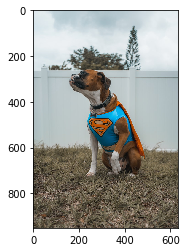

In [6]:
img = Image.open('dog.jpeg')
img = img.convert(mode='RGB')
plt.imshow(img)

The image must be prepared prior using the pre-trained model. We can pass our image to the transform function to achieve that.

In [7]:
x = transform(img)
x = torch.unsqueeze(x, dim=0)

features = model(x)

In [8]:
print(features.shape, features.dtype)

torch.Size([1, 2048]) torch.float32


## Extra

### Using features for comparison
The features computed by CNNs can be used for comparison. For example, we can compute features of one image and compared to the features of another image through a similarity measure.

In [9]:
def load_and_extract_features(model, transform, img_path):
    img = Image.open(img_path)
    plt.imshow(img)
    
    # Pré-processamento
    img = img.convert(mode='RGB')
    x = transform(img)
    x = torch.unsqueeze(x, dim=0)
    
    # Extrair features
    features = model(x)
    
    return features.detach().numpy()

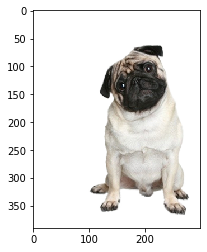

In [10]:
features_pug = load_and_extract_features(model, transform, 'pug.png')

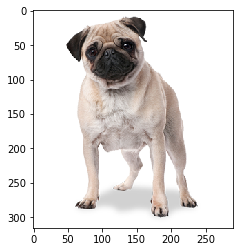

In [11]:
features_pug2 = load_and_extract_features(model, transform, 'pug2.png')

### Computing distance between features

#### Superman dog vs pug 1

In [12]:
distance = cosine(features.detach().numpy(), features_pug)
print(distance)

0.4017432928085327


#### Superman dog vs pug 2

In [13]:
distance = cosine(features.detach().numpy(), features_pug2)
print(distance)

0.36243945360183716


#### Pug 1 vs pug 2

In [14]:
distance = cosine(features_pug, features_pug2)
print(distance)

0.06241327524185181


You can see the value is smaller between the two features vectors of the pug, which indicate these two images are similar to a given degree.